In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import plot_functions as pf
import pandas as pd
import xarray as xr
import lmfit as lf

Open an initial dataset (observed values)

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()

In [3]:
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,nitrate,silicate,phosphate,oxygen,donflux,gpp,chl_a
count,365.000000,365.0,365.0,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,35.069321,0.0,0.0,0.0,10.813757,30.490284,23.956172,0.000035,15.759448,10.699419,0.600309,331.889431,1.895625,5.326875,17.024940
std,31.230162,0.0,0.0,0.0,5.574554,0.697100,0.836899,0.000030,13.483072,8.122721,0.375671,47.993865,1.193110,3.352747,8.762977
min,0.074468,0.0,0.0,0.0,2.277187,29.160912,22.598359,0.000009,0.196964,0.885625,0.111622,252.691004,0.210641,0.591919,0.000000
25%,3.119514,0.0,0.0,0.0,5.860116,29.966954,23.212432,0.000018,1.158780,3.862690,0.244642,291.622372,0.706717,1.985937,11.037168
50%,29.455765,0.0,0.0,0.0,10.534888,30.591089,23.889275,0.000025,15.044345,5.976488,0.558698,325.981203,1.895625,5.326875,17.788178
75%,63.477306,0.0,0.0,0.0,16.323988,31.004769,24.501101,0.000040,27.230134,19.984896,0.938452,362.082079,3.084533,8.667813,22.475982
max,100.457275,0.0,0.0,0.0,19.207354,32.490208,26.365789,0.000289,40.905059,25.445419,1.247792,427.340630,3.580609,10.061831,40.770156


In [4]:
par = levelface['par'].values.astype(np.float64)
temperature = levelface['temperature'].values.astype(np.float64)
no3 = levelface['nitrate'].values.astype(np.float64)
po4 = levelface['phosphate'].values.astype(np.float64)
si = levelface['silicate'].values.astype(np.float64)
o2 = levelface['oxygen'].values.astype(np.float64)
chl_a = levelface['chl_a'].values.astype(np.float64)
irradiance = par*86400/1000000 # convertion microM per second to M per day

In [5]:
ox = np.arange(1,366,1)

In [6]:
# --- Select a style
plt.style.use('classic')

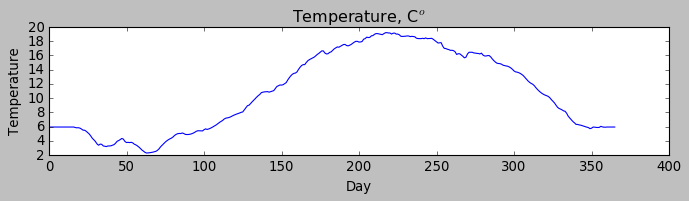

In [7]:
plt.plot(ox, temperature); plt.gcf().set_size_inches(10, 2);
plt.title('Temperature, C$^{o}$');
plt.xlabel('Day'); plt.ylabel('Temperature');

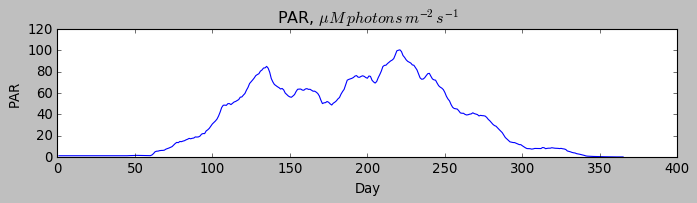

In [8]:
plt.plot(ox, par); plt.gcf().set_size_inches(10, 2);
plt.title('PAR, $\mu M\,photons\,m^{−2}\,s^{−1}$');
plt.xlabel('Day'); plt.ylabel('PAR');

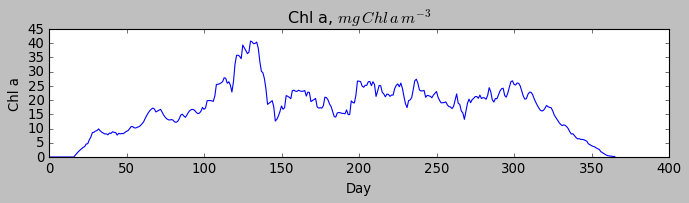

In [9]:
pf.plot_over_year('Day', 'Chl a', 'Chl a, $mg\,Chl\,a\,m^{-3}$', chl_a)

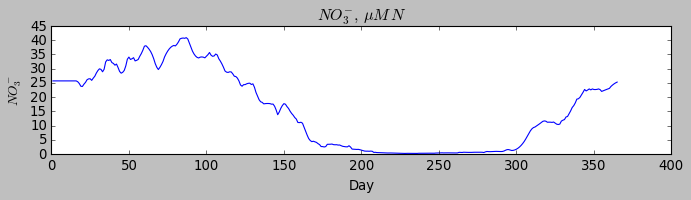

In [10]:
plt.plot(ox, no3); plt.gcf().set_size_inches(10, 2);
plt.title('$NO_{3}^{-},\,\mu M\,N$');
plt.xlabel('Day'); plt.ylabel('$NO_{3}^{-}$');

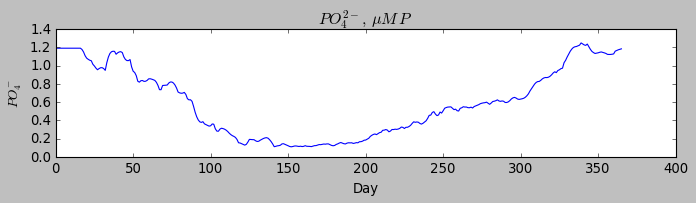

In [11]:
plt.plot(ox, po4); plt.gcf().set_size_inches(10, 2);
plt.title('$PO_{4}^{2-},\,\mu M\,P$');
plt.xlabel('Day'); plt.ylabel('$PO_{4}^{-}$');

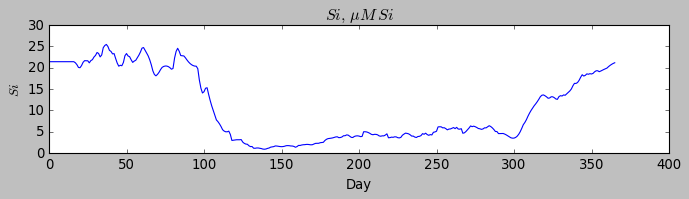

In [12]:
plt.plot(ox, si); plt.gcf().set_size_inches(10, 2);
plt.title('$Si,\,\mu M\,Si$');
plt.xlabel('Day'); plt.ylabel('$Si$');

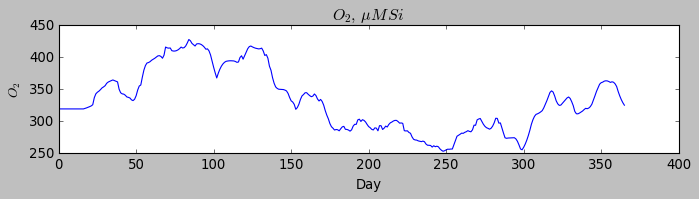

In [13]:
plt.plot(ox, o2); plt.gcf().set_size_inches(10, 2);
plt.title('$O_{2},\,\mu M\,Si$');
plt.xlabel('Day'); plt.ylabel('$O_{2}$');

Universal limiters and inhibitors:

In [14]:
def linearlimiter(k, r):
    return np.minimum(r/k, 1)

def monodlimiter(ks, r):
    return (r/(r+ks))

def monodinhibitor(ks, r):
    return (ks/(ks+r))

def hyper_limiter(threshold_value, r, coef):
    return 0.5+0.5*np.tanh((r-threshold_value)*coef)

def hyper_inhibitor(threshold_value, r, coef):
    return 0.5-0.5*np.tanh((r-threshold_value)*coef)

def exp_inhibitor(ks, r):
    return np.exp(-ks*r)

def exp_limiter(ks, r):
    return 1-np.exp(-ks*r)

def sigmoid_powered(ks, r, power):
    return np.power(r, power)/(np.power(ks, power)+np.power(r, power))

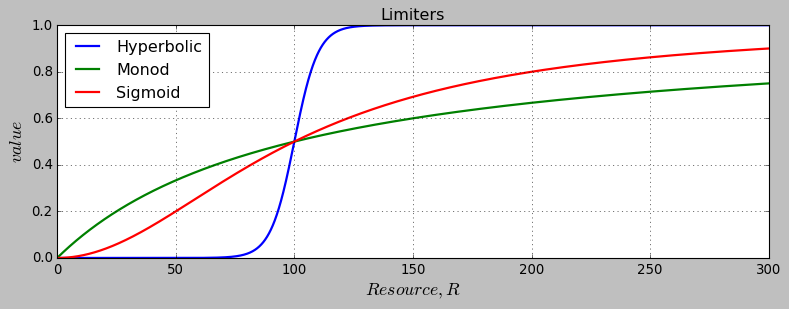

In [39]:
oxnut = np.arange(0, 300, 0.1)
# --- get an empty Figure and add an Axes
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1) # row-col-num
# --- line plot data on the Axes
ax.plot(oxnut, hyper_limiter(100, oxnut, 0.1), 'b-', linewidth=2, label=r'Hyperbolic')
ax.plot(oxnut, monodlimiter(100, oxnut), 'g-', linewidth=2, label=r'Monod')
ax.plot(oxnut, sigmoid_powered(100, oxnut, 2), 'r-', linewidth=2, label=r'Sigmoid')
# --- add title and axis labels
ax.set_title('Limiters')
ax.set_ylabel(r'$ value$', fontsize=16)
ax.set_xlabel(r'$Resource, R$', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='best')
# --- add grid – not in default classic style
ax.grid(True)
# --- improve the layout
fig.tight_layout(pad=1)

Light limiters:

In [16]:
def limlight(optimum, par):
    return (par/optimum)*np.exp(1-par/optimum)

Temperature limiters:

In [17]:
# ersem temperature limiter
def limt(q10, temperature):
    return (np.power(q10,(temperature-10)/10)
           -np.power(q10,(temperature-32)/3 ) )

Chl:C relationship, Cloern et al., 1995: $\frac{Chl\,a}{C} = A_{0} + A e^{BT}e^{-CI}\tau$

In [18]:
def ChlCratio(temperature, irradiance, nutrient_limiter):
    """temperature - [C,
       irradiance - [mol quanta m-2 d-1]"""
    
    A0 = 0.003 # minimal Chl:C ratio
    A = 0.0154; B = 0.050; C = 0.059 # achieved by experiment
    
    return A0+A*np.exp(B*temperature)*np.exp(-1*C*irradiance)*nutrient_limiter

Light attenuation

In [19]:
def light_attenuation(k, z, I):
    """
    k is attenuation coefficient [m-1]
    z is depth, [m]
    I is the instantaneous irradiance at depth z (PAR), [microM quanta m-2 s-1]
    or daily irradiane [mol quanta m-2 d-1]
    """
    return I*np.exp(-1*k*z)

Calculate nutrient limiters

In [20]:
no3_limiter = sigmoid_powered(1, no3, 2)
si_limiter  = sigmoid_powered(0.5, si, 2)
po4_limiter = sigmoid_powered(0.2, po4, 2)

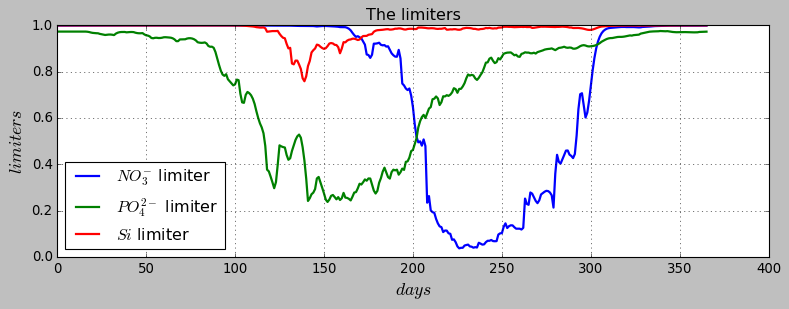

In [21]:
# --- get an empty Figure and add an Axes
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1) # row-col-num
# --- line plot data on the Axes
ax.plot(ox, no3_limiter, 'b-', linewidth=2, label=r'$NO_{3}^{-}$ limiter')
ax.plot(ox, po4_limiter, 'g-', linewidth=2, label=r'$PO_{4}^{2-}$ limiter')
ax.plot(ox, si_limiter, 'r-', linewidth=2, label=r'$Si$ limiter')
# --- add title and axis labels
ax.set_title('The limiters')
ax.set_ylabel(r'$limiters$', fontsize=16)
ax.set_xlabel(r'$days$', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='best')
# --- add grid – not in default classic style
ax.grid(True)
# --- improve the layout
fig.tight_layout(pad=1)

In [22]:
nutrient_limiter = [np.min([x, y, z]) for x, y, z in zip(no3_limiter, si_limiter, po4_limiter)];

In [23]:
ChlCratio_array = ChlCratio(temperature, light_attenuation(k=0.4, z=0.625, I=irradiance), nutrient_limiter)

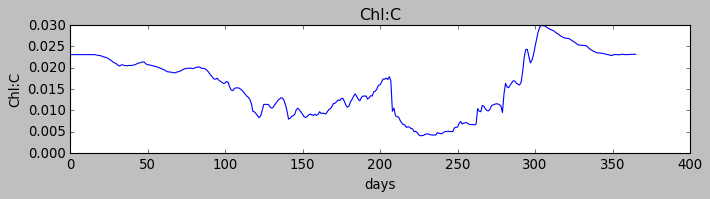

In [24]:
ox = np.arange(1,366,1)
plt.plot(ox,ChlCratio_array); plt.gcf().set_size_inches(10,2);
plt.title('Chl:C'); plt.xlabel('days'); plt.ylabel('Chl:C');

Photoperiod, hours

In [25]:
def photoperiod():
    import datetime
    from astral import Astral
    
    city_name = 'Vilnius'
    a = Astral()
    a.solar_depression = 'civil'
    city = a[city_name]
    
    date_list = pd.date_range(start='1/1/2018', end='31/12/2018')
    sun = [city.sun(date=x, local=True) for x in date_list] 
    diff = [sun[x]['sunset']-sun[x]['sunrise'] for x in range(0,len(sun))]
    
    return [diff[x].seconds/60/60 for x in range(0,len(diff))]

In [26]:
def photoperiod2(latitude):
    """
    From the Fennel "Marine Modelling" - page 130 and ersem zenith_angle module
    """
    
    latitude = np.pi/180*latitude
    
    a0 = 0.006918
    a1 =-0.399912
    a2 =-0.006758
    a3 =-0.002697
    b1 = 0.070257
    b2 = 0.000907
    b3 = 0.001480
    
    days = np.arange(1,366,1)
    th0 = np.pi*days/182.5
    th02 = 2*th0
    th03 = 3*th0
    
    delta =(a0
          + a1*np.cos(th0)+b1*np.sin(th0)
          + a2*np.cos(th02)+b2*np.sin(th02)
          + a3*np.cos(th03)+b3*np.sin(th03))
    
    wh = (2*np.pi)/24
    deltaday = (2/wh)*np.arccos(-np.tan(latitude)*np.tan(delta))
    
    return deltaday

Biomass specific photosynthetic rate, $mg\,C\,(mg\,Chl\,a\,d)^{-1}$: $P^{B} = D p^{B}_{m}(1 - \exp{\frac{I_{t} \alpha}{p^{B}_{m}}})$

In [27]:
def biorate(D, pbm, alpha, I):
    """
    D is photoperiod, hours
    pbm is the maximum hourly rate of photosynthesis, [mg C (mg Chl a h)-1], by experiment
    alpha is photosynthetic efficiency at low irradiance, by experiment
    I is instanteneous irradance, PAR [microM quanta m-2 s-1]
    """
    return (D*pbm*(1-np.exp(-1*I*alpha/pbm)))

In [28]:
photoperiod_array = np.array(photoperiod2(54.88))
biorate_array = biorate(D=photoperiod_array, pbm=8, alpha=0.05, I=light_attenuation(0.5,0.625, par))

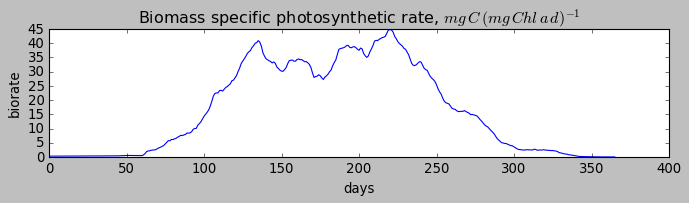

In [29]:
plt.plot(ox, biorate_array); plt.gcf().set_size_inches(10,2);
plt.title('Biomass specific photosynthetic rate, $mg\,C\,(mg\,Chl\,a\,d)^{-1}$');
plt.xlabel('days'); plt.ylabel('biorate');

Daily specific growth rate with respiration included: $\mu = R_{1} P^{B}\frac{Chl\,a}{C} - R_{0}$

In [30]:
def daily_growth(biorate, ChlCratio):
    """
    Coefficiens inside evaluate respiration;
    biorate is the daily rate of photosynthesis, [mg C (mg Chl a d)-1]
    ChlCratio, joint nutrients limiter
    """
    answer = 0.85*biorate*ChlCratio-0.015
    
    return np.max([answer, 0])
    #return [np.max([0, x]) for x in answer]

In [31]:
def excretion(kexc, phy):
    return kexc*phy

def mortality(kmrt, phy, o2):
    return phy*(kmrt+hyper_inhibitor(60, o2, 1)*0.45+hyper_inhibitor(20, o2, 1)*0.45)

Gross primary production

In [32]:
def daily_growth_rate(kno3, ksi, kpo4, 
                      k, depth,
                      pbm, alpha,
                      no3_d, si_d, po4_d,
                      temperature_d, irradiance_d, photoperiod_d, par_d):
    """It returns net primary production, so respiration is included
       kno3, ksi, kpo4, k, pbm, alpha - parameters
       other ones - variables for the current day"""
    
    no3_limiter = sigmoid_powered(kno3, no3_d, 2)
    si_limiter  = sigmoid_powered(ksi, si_d, 2)
    po4_limiter = sigmoid_powered(kpo4, po4_d, 2)
    nutrient_limiter = np.min([no3_limiter, si_limiter, po4_limiter])
    
    ChlCratio_d = ChlCratio(temperature_d, light_attenuation(k=k, z=depth, I=irradiance_d), nutrient_limiter)
    biorate_d = biorate(D=photoperiod_d, pbm=pbm, alpha=alpha, I=light_attenuation(k=k, z=depth, I=par_d))
    daily_growth_d = daily_growth(biorate_d, ChlCratio_d)
    
    return daily_growth_d

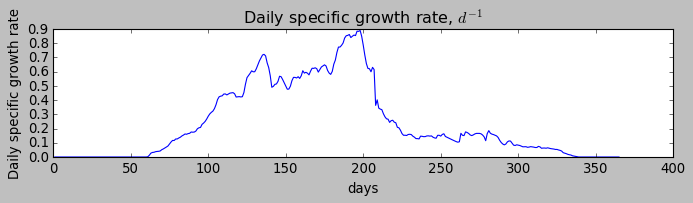

In [33]:
daily_growth_array = [daily_growth_rate(
                              kno3=1, ksi=0.5, kpo4=0.1,
                              k=0.04, depth=0.625,
                              pbm=8, alpha=0.05,
                              no3_d=x1, si_d=x2, po4_d=x3,
                              temperature_d=x4, irradiance_d=x5, photoperiod_d=x6, par_d=x7) 
                      for x1, x2, x3, x4, x5, x6, x7 in 
                      zip(no3, si, po4, temperature, irradiance, photoperiod_array, par)]

plt.plot(ox,daily_growth_array); plt.gcf().set_size_inches(10,2);
plt.title('Daily specific growth rate, $d^{-1}$');
plt.xlabel('days'); plt.ylabel('Daily specific growth rate');

Phytoplankton itself

In [34]:
def c_from_ratio(chl_a, temperature, 
                 k, I, depth,
                 kno3, ksi, kpo4,
                 no3, si, po4):
    """k, depth, kno3, ksi, kpo4 - parameters"""
    
    no3_limiter = monodlimiter(kno3, no3)
    si_limiter = monodlimiter(ksi, si)
    po4_limiter = monodlimiter(kpo4, po4)
    
    nutrient_limiter = [np.min([x, y, z]) for x, y, z in zip(no3_limiter, si_limiter, po4_limiter)];
    
    return (  chl_a
            / ChlCratio(temperature, light_attenuation(k=k, z=depth, I=I), nutrient_limiter))

In [35]:
PhyC_array = c_from_ratio(chl_a=chl_a, temperature=temperature,
                          k=0.04, I=irradiance, depth=0.625,
                          kno3=1, ksi=0.5, kpo4=0.1,
                          no3=no3, si=si, po4=po4)

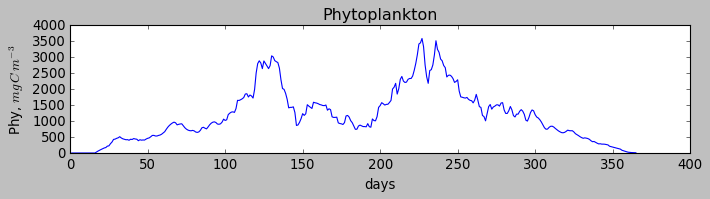

In [36]:
plt.plot(ox,PhyC_array); plt.gcf().set_size_inches(10,2);
plt.title('Phytoplankton'); plt.xlabel('days'); plt.ylabel('Phy, $mg\,C\,m^{-3}$');